In [49]:
!nvidia-smi

Thu Sep 26 21:05:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0              34W /  70W |    279MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [50]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16965, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 16965 (delta 82), reused 100 (delta 49), pack-reused 16805 (from 1)
Receiving objects: 100% (16965/16965), 15.71 MiB | 15.44 MiB/s, done.
Resolving deltas: 100% (11615/11615), done.
/content/drive/MyDrive/Helmet/yolov5/yolov5


In [51]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))


Setup complete. Using torch 2.4.1+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


In [52]:
%pwd


'/content/drive/MyDrive/Helmet/yolov5/yolov5'

In [53]:
dataset.location


'/content/drive/MyDrive/Helmet/helmate-1'

In [54]:
%cd /content/drive/MyDrive/Helmet/yolov5

/content/drive/MyDrive/Helmet/yolov5


In [55]:
dataset.location


'/content/drive/MyDrive/Helmet/helmate-1'

In [56]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {dataset.location}/data.yaml

names:
- helmet
- license_plate
- motorcyclist
nc: 3
roboflow:
  license: CC BY 4.0
  project: helmate-gxxio
  url: https://universe.roboflow.com/project-szzpt/helmate-gxxio/dataset/1
  version: 1
  workspace: project-szzpt
test: ../test/images
train: helmate-1/train/images
val: helmate-1/valid/images


In [57]:

# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [58]:
num_classes


'3'

In [59]:

#this is the model configuration we will use for our tutorial
%cat /content/drive/MyDrive/Helmet/yolov5/models/yolov5s.yaml

# parameters
nc: 3  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13
   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1,

In [60]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [61]:
%%writetemplate /content/drive/MyDrive/Helmet/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13
   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]


In [78]:
# train yolov5s on custom data for 200 epochs
# time its performance
%%time
%cd /content/drive/MyDrive/Helmet/yolov5
!python train.py --img 416 --batch 16 --epochs 500 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights 'yolov5s.pt' --name yolov5s_results  --cache


Streaming output truncated to the last 5000 lines.
  with torch.cuda.amp.autocast(amp):
    237/499      1.97G    0.04185    0.02053   0.003023        153        416:  86% 6/7 [00:01<00:00,  4.06it/s]/content/drive/MyDrive/Helmet/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
    237/499      1.97G    0.04242    0.02091   0.002792         17        416: 100% 7/7 [00:01<00:00,  4.12it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:00<00:00,  2.62it/s]
                   all         28        146      0.845      0.761      0.793      0.433

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
  0% 0/7 [00:00<?, ?it/s]/content/drive/MyDrive/Helmet/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
%cd /content/drive/MyDrive/Helmet/

/content/drive/MyDrive/Helmet


In [29]:
ls

 data.yaml    Helmet-Detection-Project-1/                runs/
 dog.jpeg    'Helmet Detection Project.v1i.yolov8.zip'   yolov8n.pt
 helmate-1/  'Helmet detection using yolov8'             yolov8s.pt


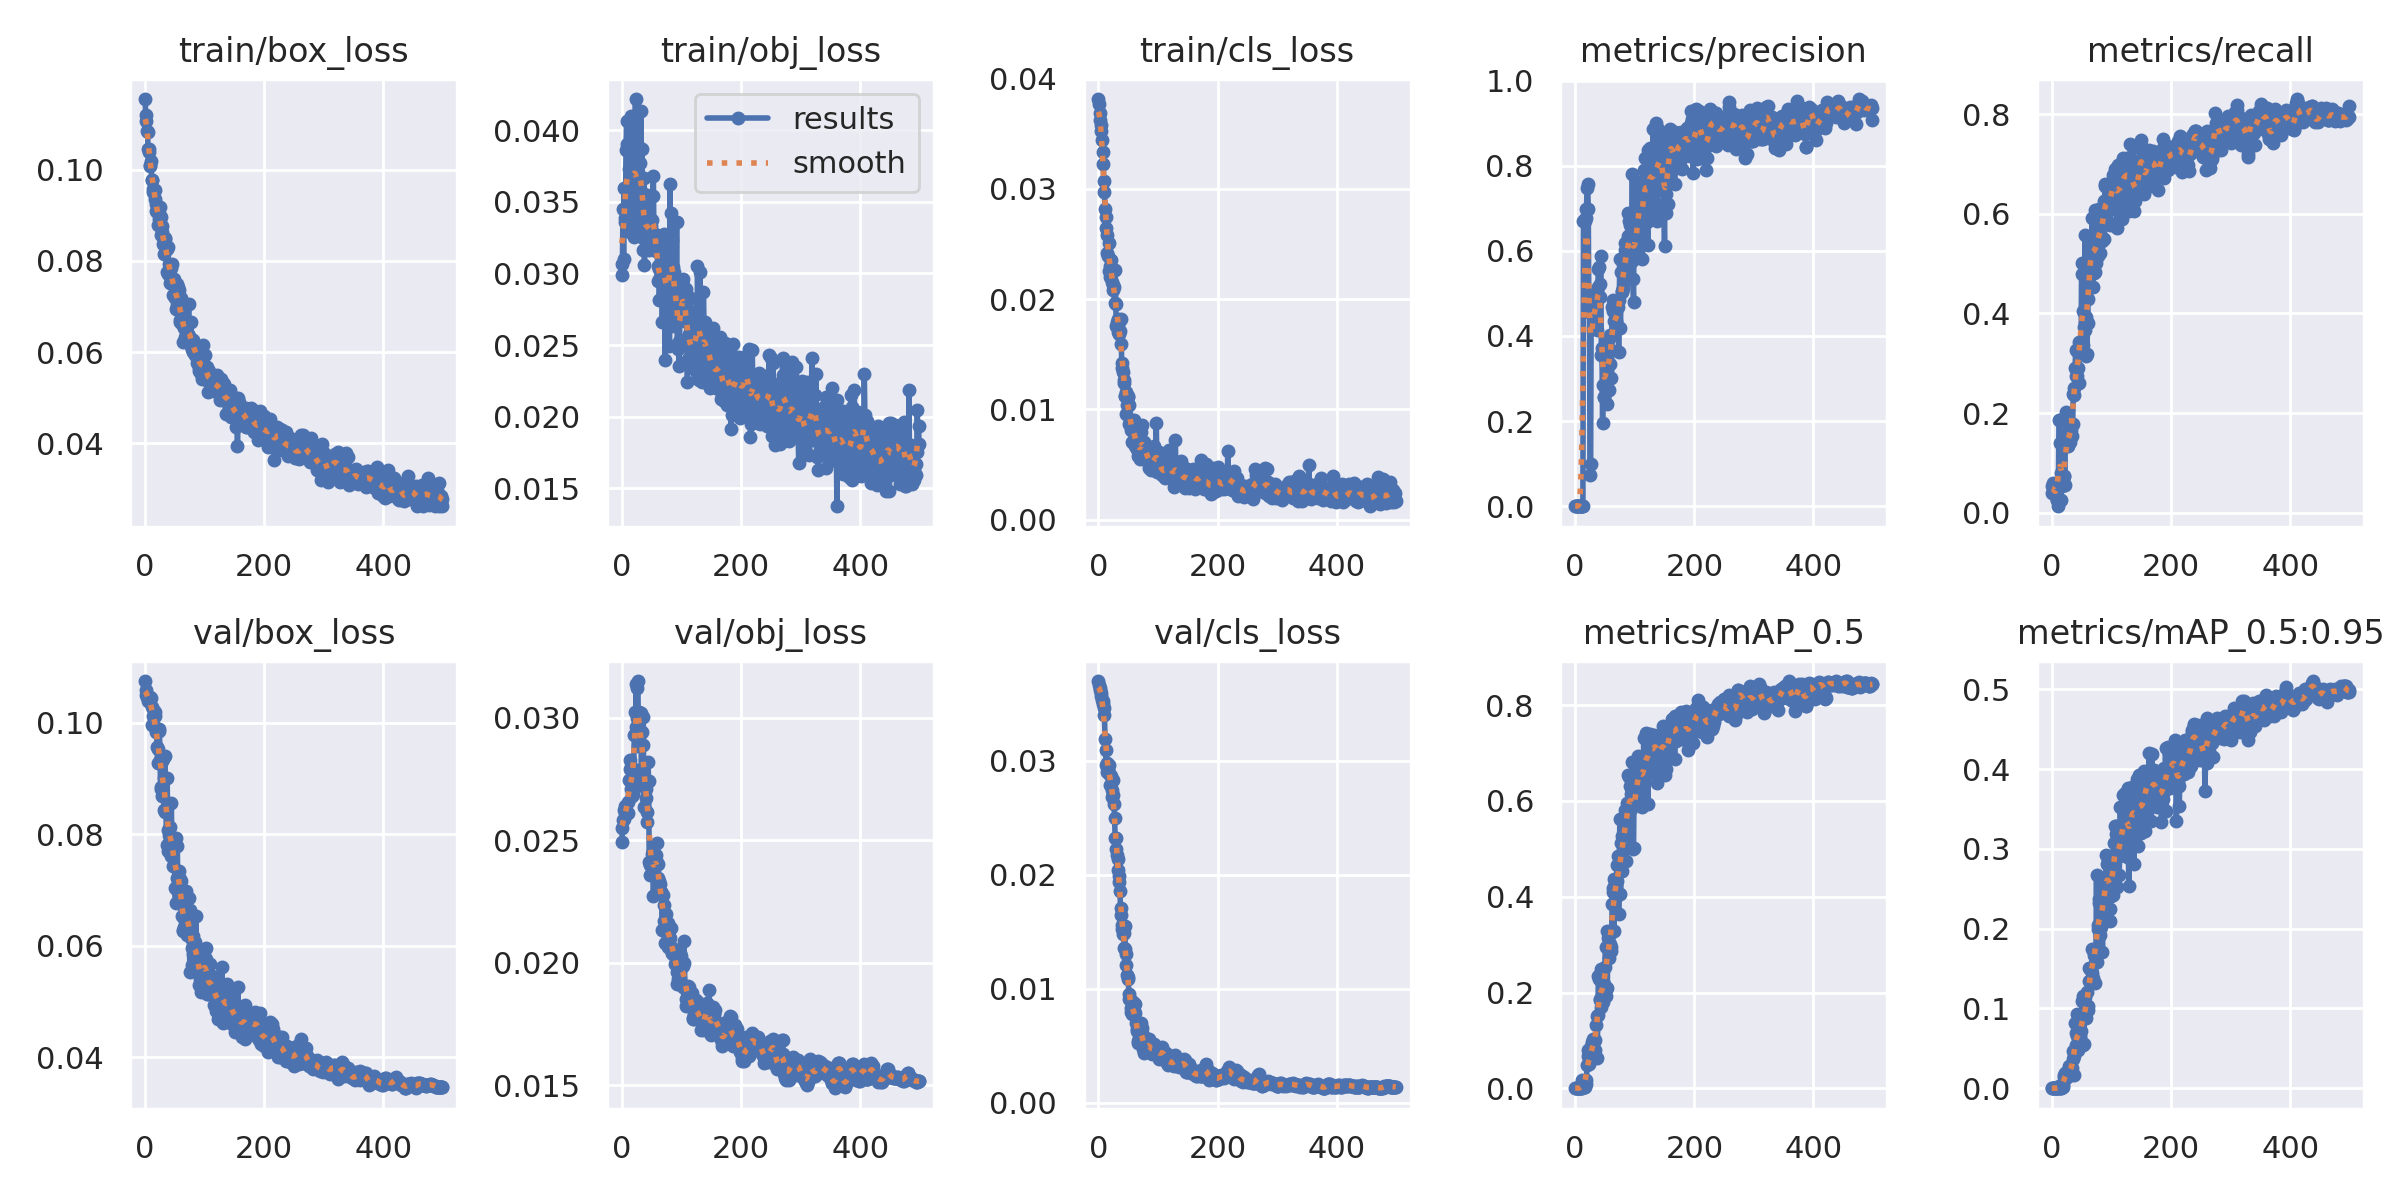

In [80]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/drive/MyDrive/Helmet/yolov5/runs/train/yolov5s_results3/results.png', width=1000)  # view results.png

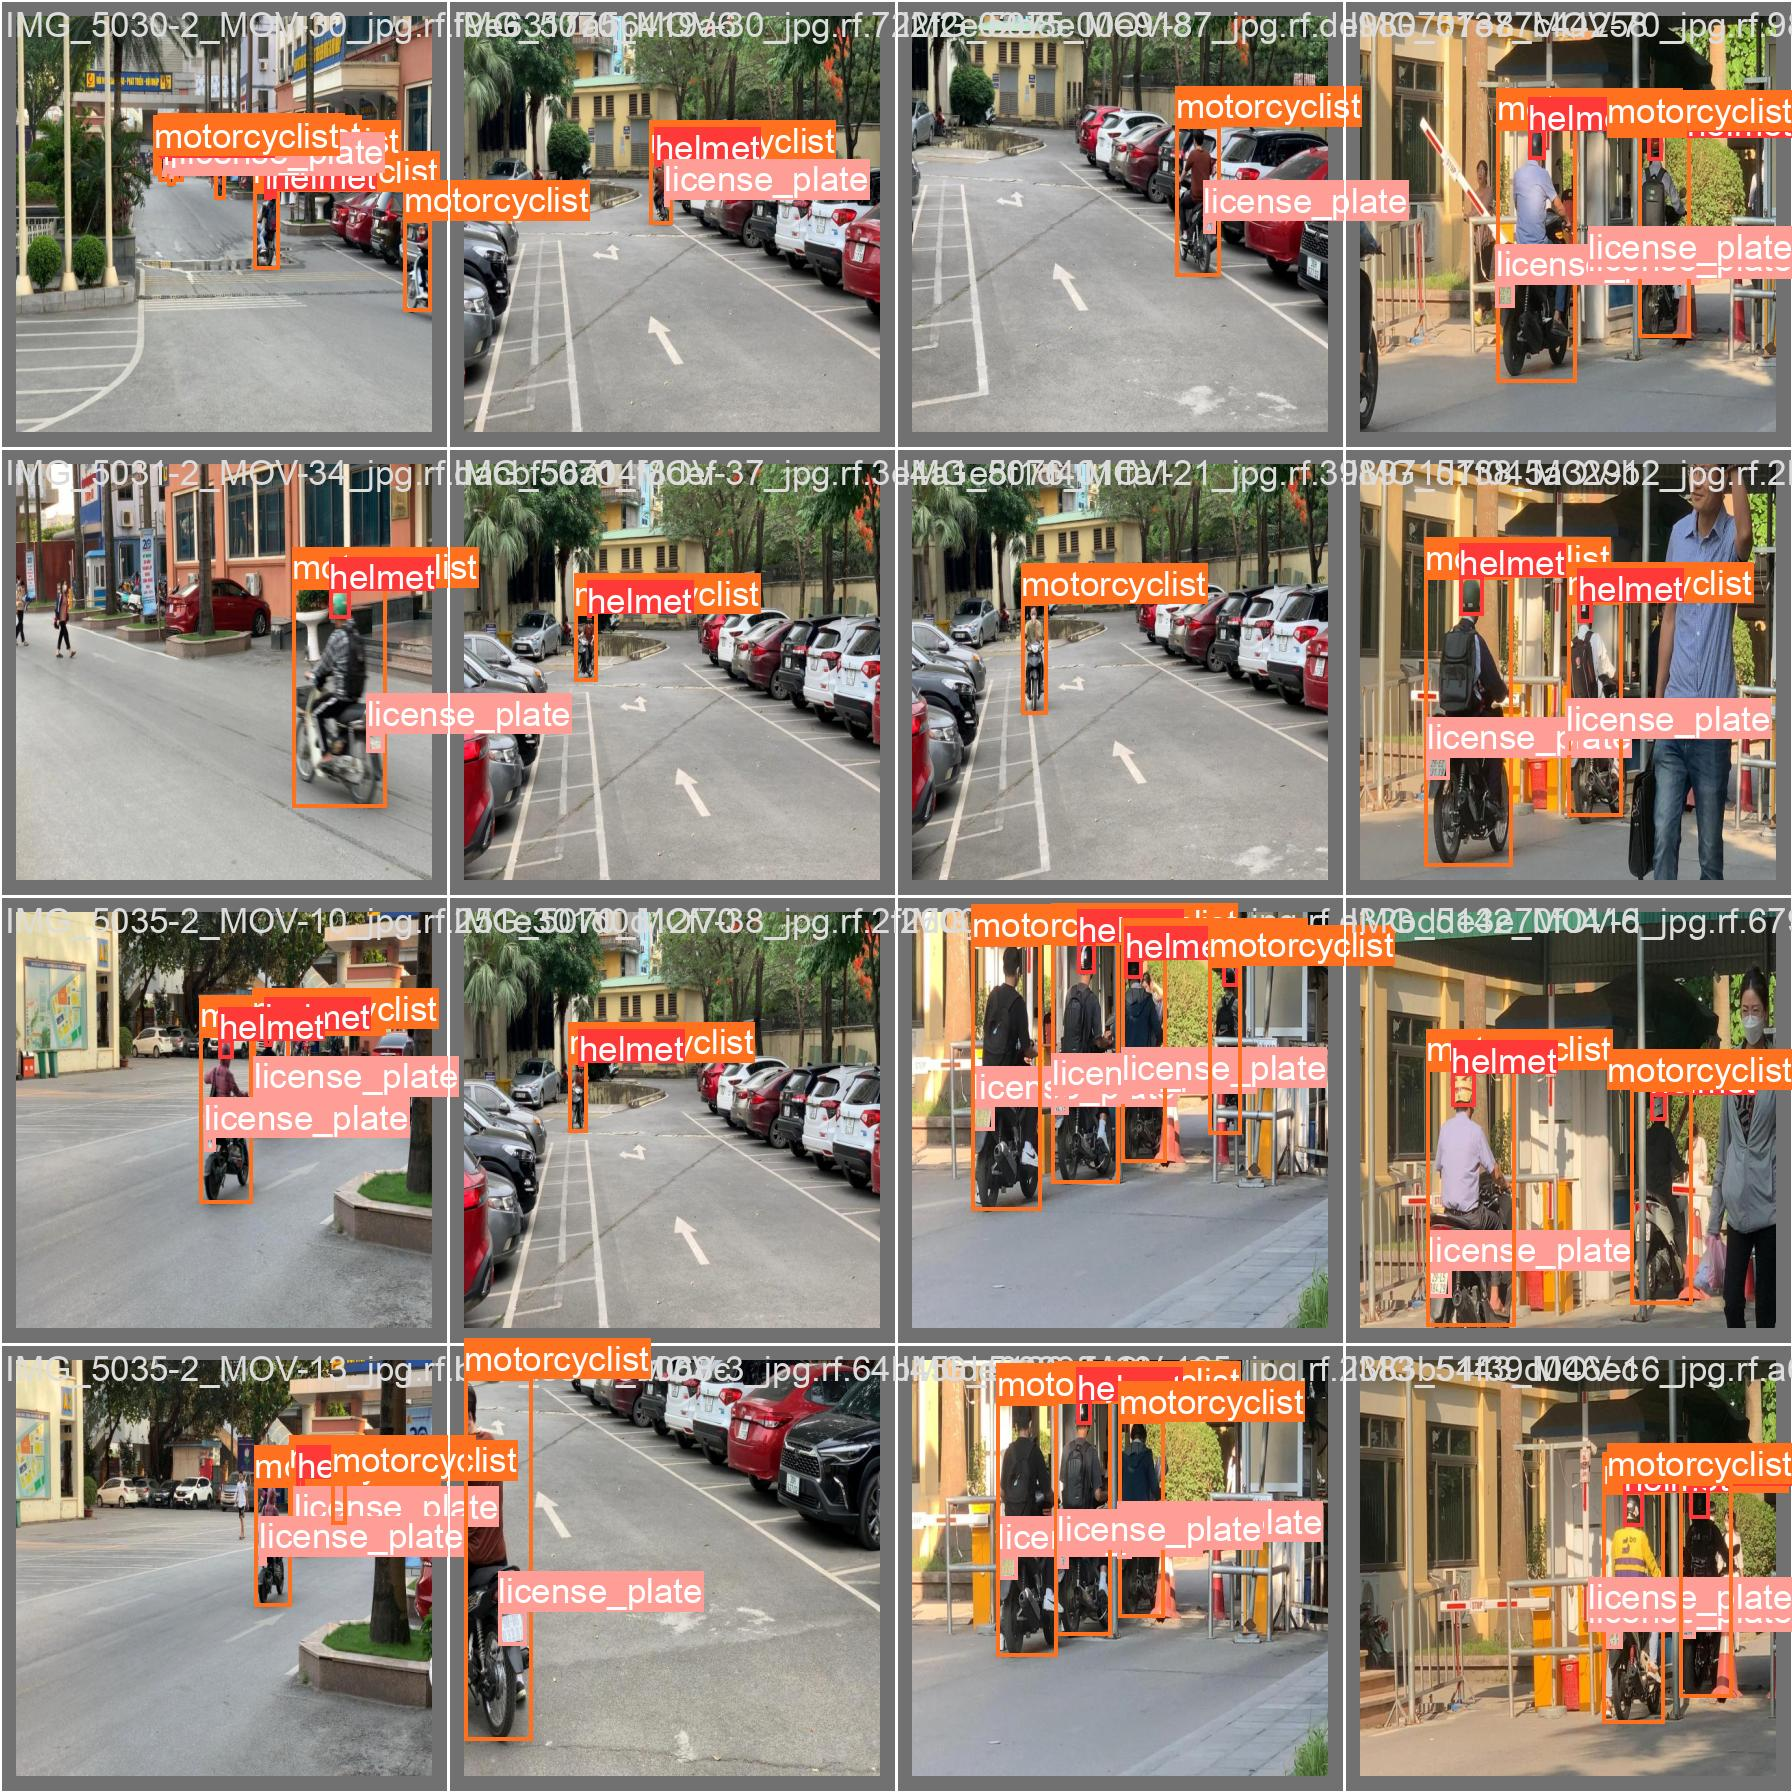

In [81]:
Image(filename='/content/drive/MyDrive/Helmet/yolov5/runs/train/yolov5s_results3/val_batch0_labels.jpg', width=900)


GROUND TRUTH AUGMENTED TRAINING DATA:


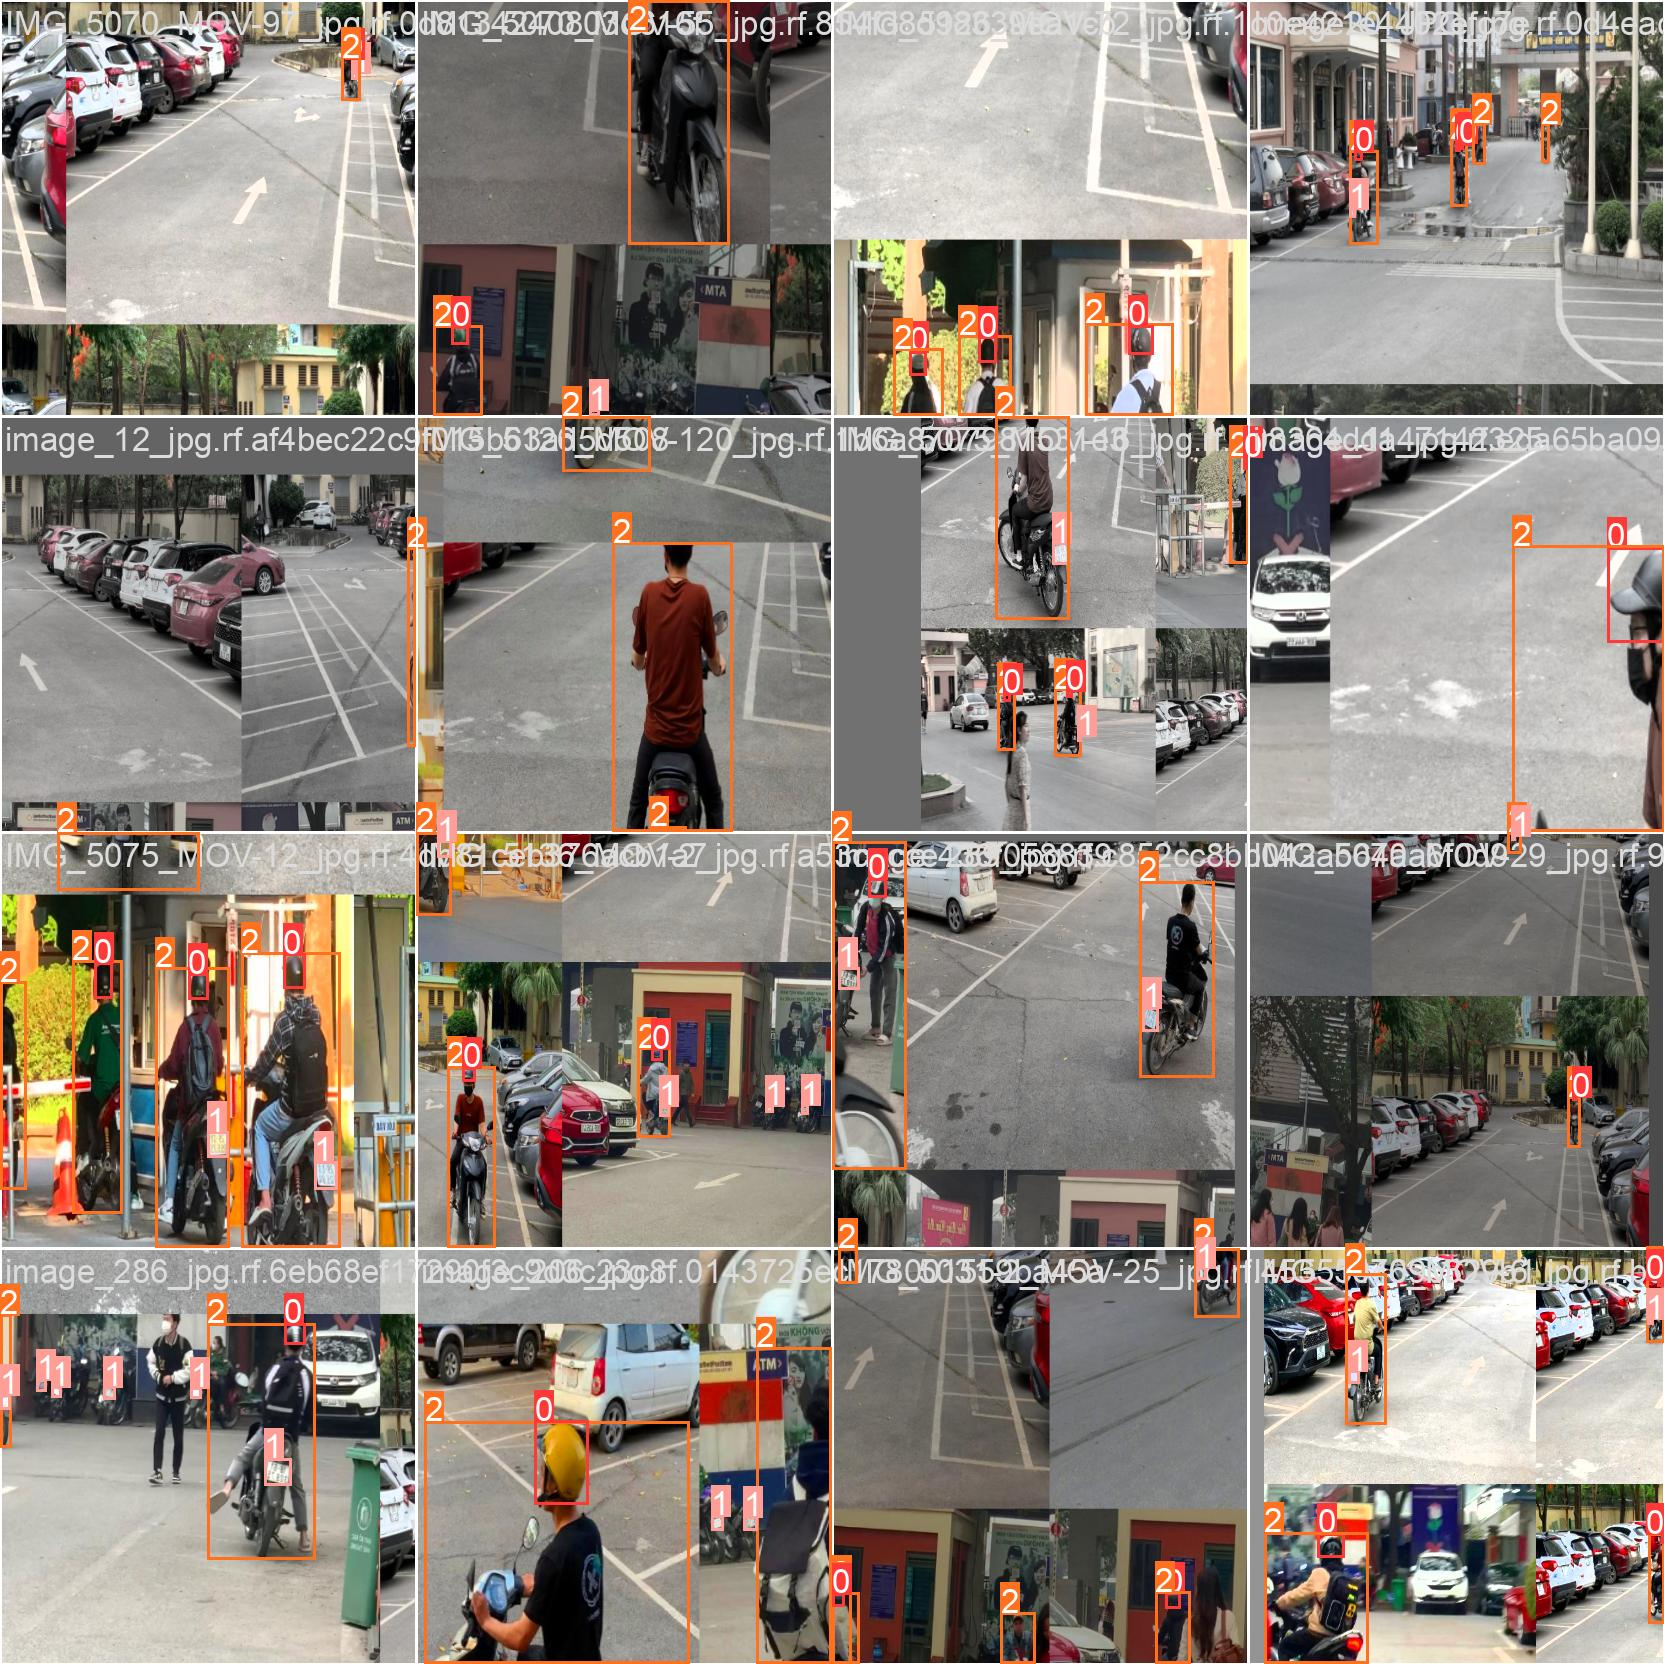

In [82]:

# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/drive/MyDrive/Helmet/yolov5/runs/train/yolov5s_results3/train_batch0.jpg', width=900)

In [70]:
# trained weights are saved by default in our weights folder
%ls runs/


train/


In [83]:
%ls /content/drive/MyDrive/Helmet/yolov5/runs/train/yolov5s_results3/weights


best.pt  last.pt


In [84]:
%cd /content/drive/MyDrive/Helmet/yolov5

!python detect.py --weights /content/drive/MyDrive/Helmet/yolov5/runs/train/yolov5s_results3/weights/best.pt --img 416 --conf 0.4 --source /content/drive/MyDrive/Helmet/helmate-1/test/images


/content/drive/MyDrive/Helmet/yolov5
detect: weights=['/content/drive/MyDrive/Helmet/yolov5/runs/train/yolov5s_results3/weights/best.pt'], source=/content/drive/MyDrive/Helmet/helmate-1/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-368-gb163ff8d Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7251912 parameters, 0 gradients
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/14 /content/drive/MyDrive/Helmet/helmate-1/test/images/IMG_5034-2_MOV-19_jpg.rf.814666842233f5e818477a35ead980ce.jpg: 416x416 1 helmet, 2 license_plat

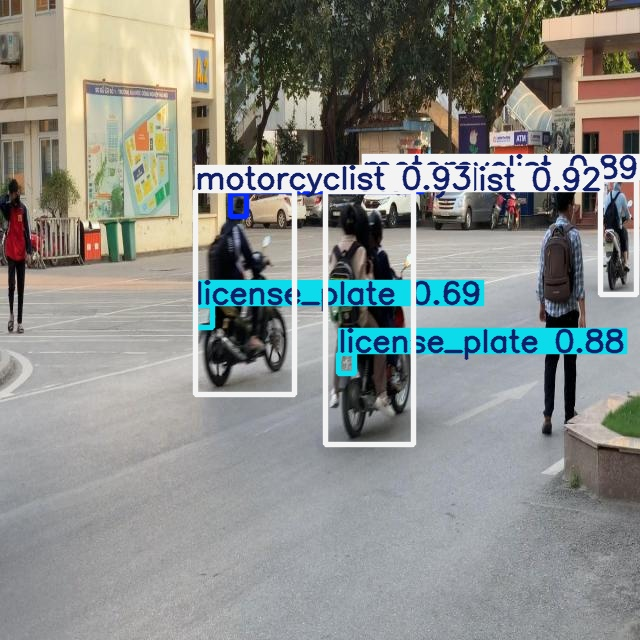

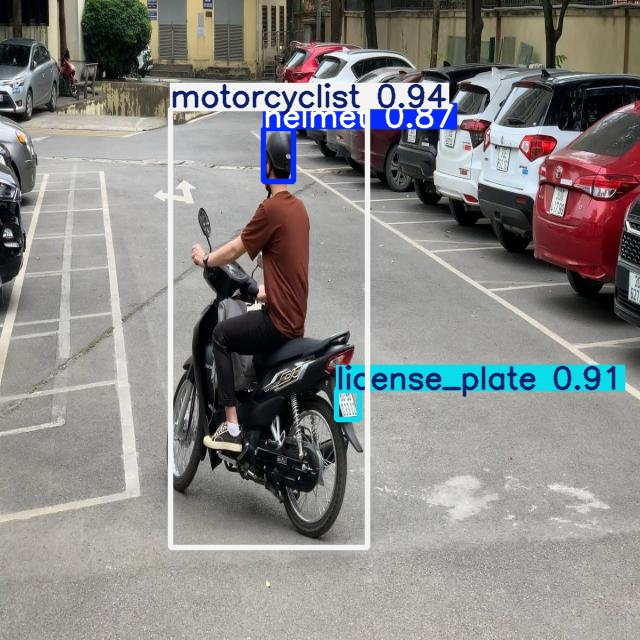

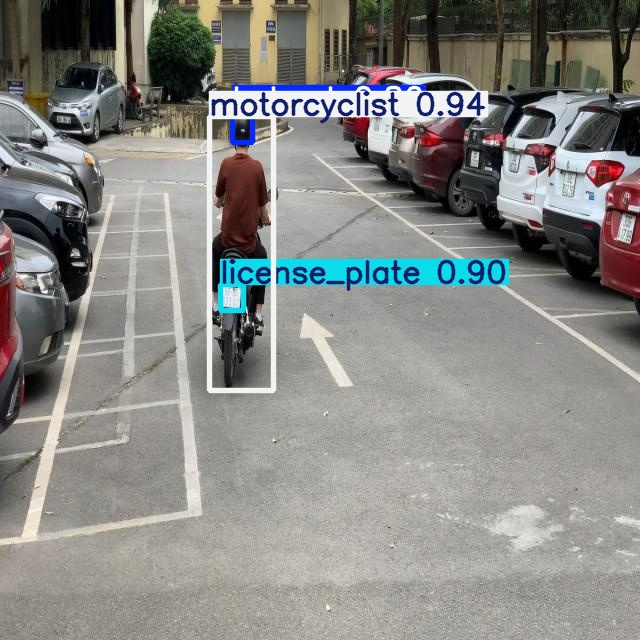

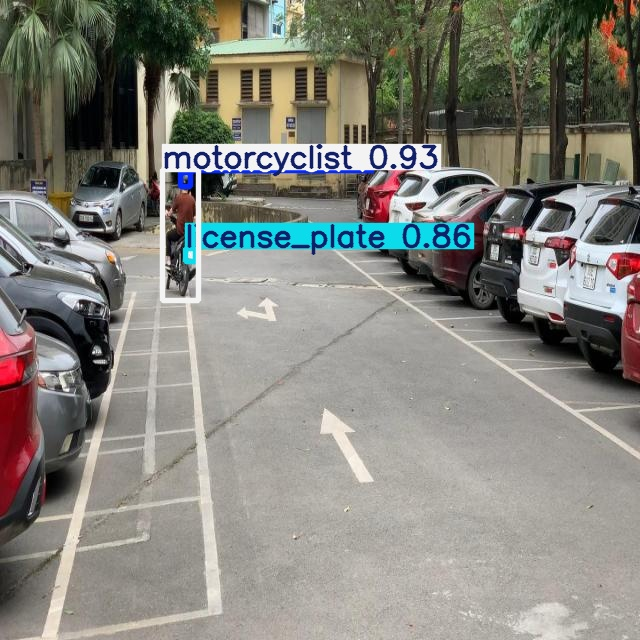

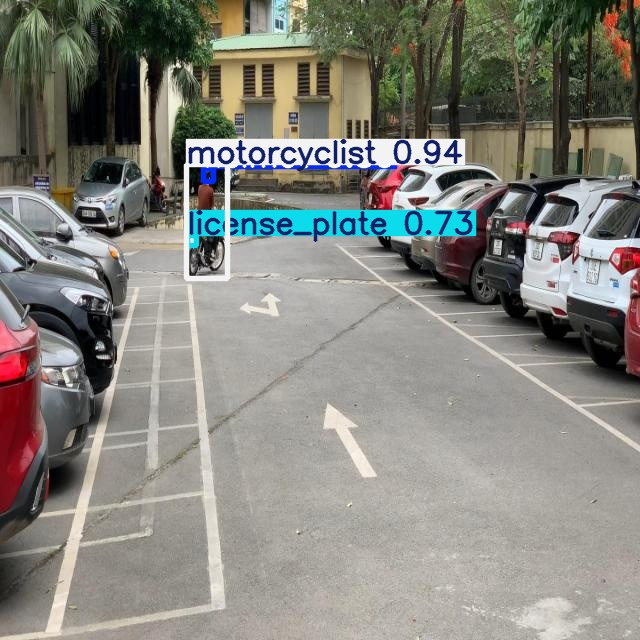

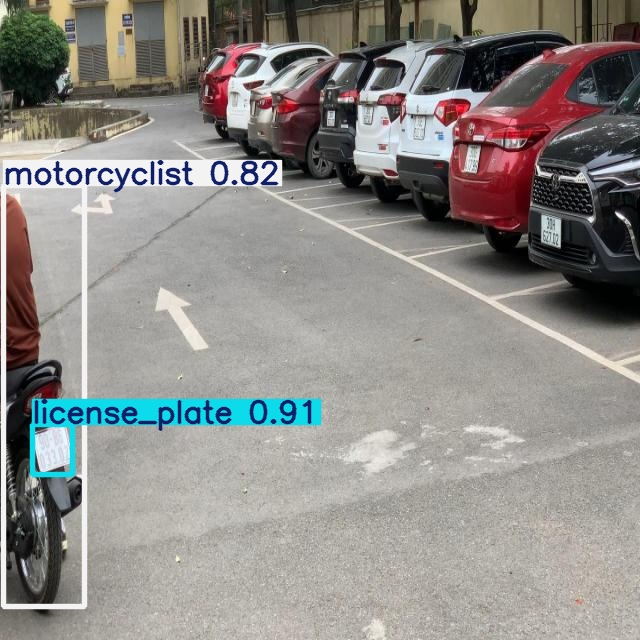

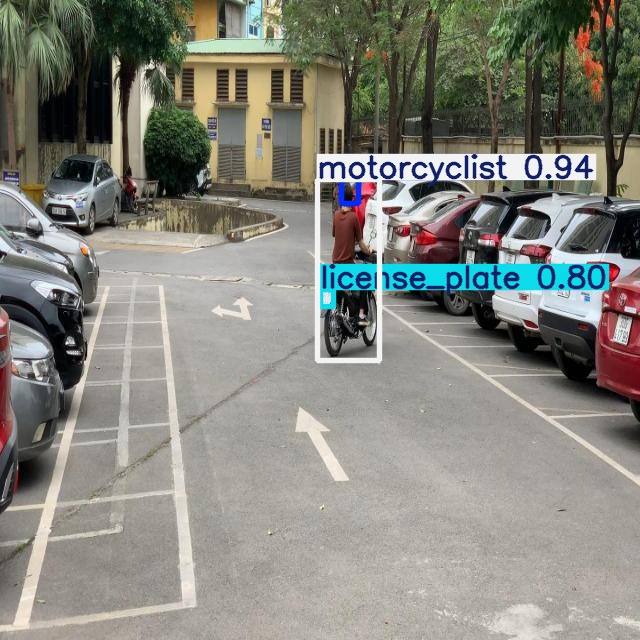

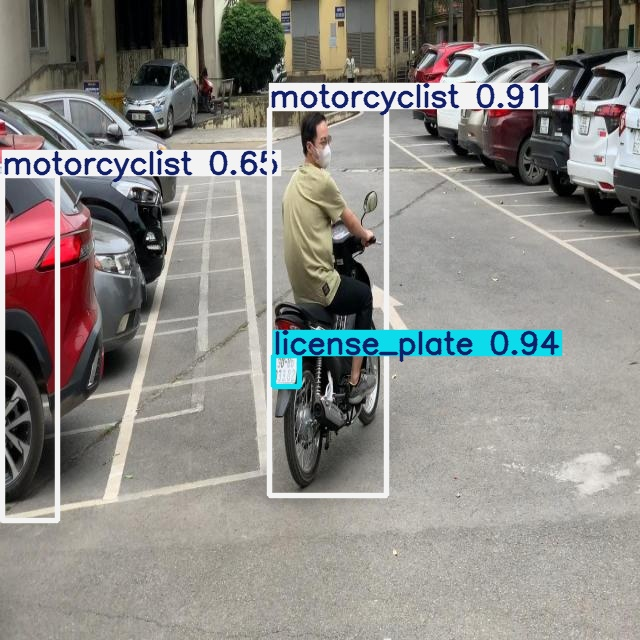

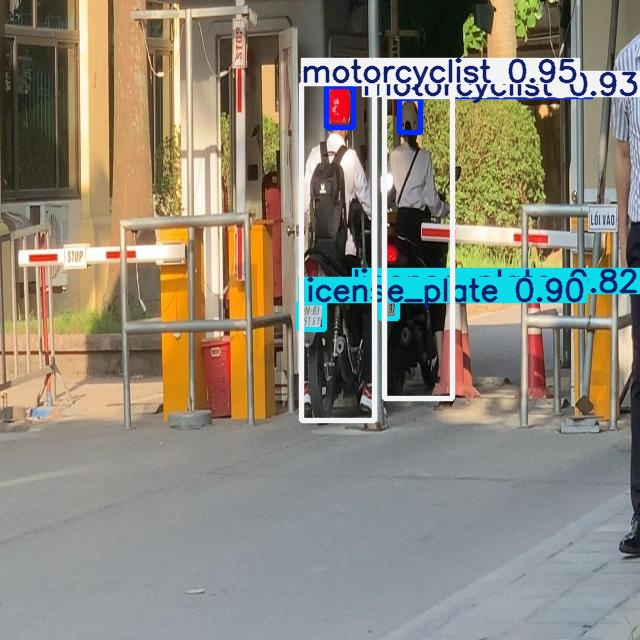

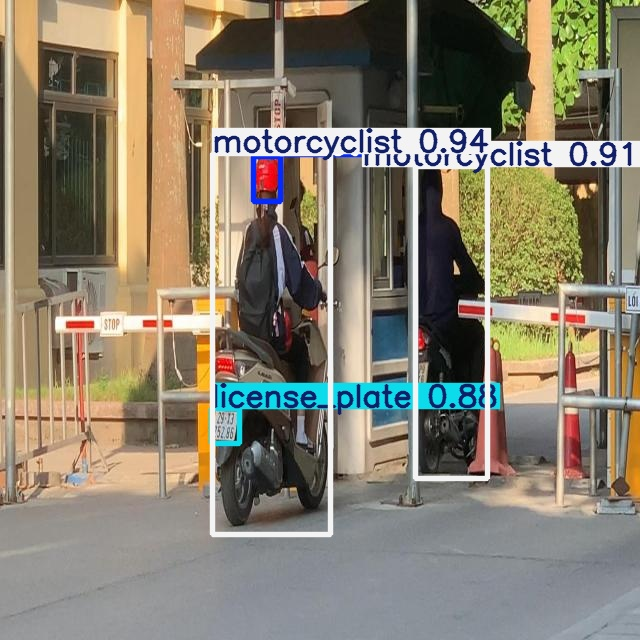

In [85]:

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/drive/MyDrive/Helmet/yolov5/runs/detect/exp4/*.jpg')[:10]: #assuming JPG
    display(Image(filename=imageName))

In [91]:
%cd /content/drive/MyDrive/Helmet/yolov5

!python detect.py --weights /content/drive/MyDrive/Helmet/yolov5/runs/train/yolov5s_results3/weights/best.pt --img 416 --conf 0.4 --source /content/1.jpg


/content/drive/MyDrive/Helmet/yolov5
detect: weights=['/content/drive/MyDrive/Helmet/yolov5/runs/train/yolov5s_results3/weights/best.pt'], source=/content/1.jpg, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-368-gb163ff8d Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7251912 parameters, 0 gradients
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/1.jpg: 416x288 1 motorcyclist, 29.4ms
Speed: 0.4ms pre-process, 29.4ms inference, 570.1ms NMS per image at shape (1, 3, 416, 416)
Results saved to runs/detect/exp10


In [1]:
# !python detect.py --weights /content/drive/MyDrive/Helmet/yolov5/runs/train/yolov5s_results3/weights/best.pt --img 416 --conf 0.4 --source /content/vecteezy_bekasi-indonesia-in-may-2022-traffic-on-one-of-the-roads_24493170.mp4
